# Quantum Mechanics Wave Evolution

pd: $\hbar = 1$

where $H$ is the Hamiltonian, expressed as:

$$
H = - \frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V
$$

2nd order derivative is discretized as:

$$
\frac{\partial^2 \psi^t_x}{\partial x^2} = \frac{\psi^t_{x+1} - 2 \psi^t_x + \psi^t_{x-1}}{(\Delta x)^2} = \frac{D^2}{(\Delta x)^2} \psi^t_x
$$

the discretization of the 2nd order derivative ends up as a matrix:

$$
D^2 = \left( \begin{matrix} 
-2 && 1 && 0 && 0 && \dots && 0 && 0 \\
1 && -2 && 1 && 0 && \dots && 0 && 0 \\
0 && 1 && -2 && 1 && \dots && 0 && 0 \\
0 && 0 && 1 && -2 && \dots && 0 && 0 \\
\vdots && \vdots && \vdots && \vdots && \ddots && \vdots && \vdots \\
0 && 0 && 0 && 0 && \dots && -2 && 1 \\
0 && 0 && 0 && 0 && \dots && 1 && -2 \\
\end{matrix} \right)
$$



So:
$$
H \psi_n = E \psi_n
$$

$$
- \alpha \frac{D^2}{(\Delta x)^2} \psi_n + \psi_n V - \psi_n E_n = 0
$$

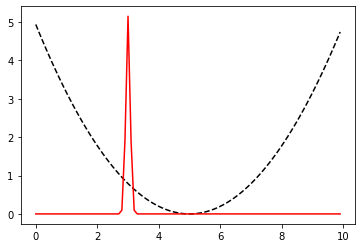

In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

# Potential V(x)
x_Vmin = 5
T = 1
omega = 2 * np.pi / T
k = omega**2
dx = 0.1
x = np.arange(0, 10, dx)

kx = 0.1
m = 1
sigma = 0.1
x0 = 3.0
A = 1.0 / (sigma * np.sqrt(np.pi))

# Convert x and V to PyTorch tensors
x_tensor = torch.as_tensor(x, dtype=torch.float32)
V_tensor = torch.as_tensor(0.5 * k * (x - x_Vmin)**2, dtype=torch.float32)

# Create a parameter tensor for psi with requires_grad=True for backpropagation
psi_tensor = nn.Parameter(np.sqrt(A) * torch.exp(-(x_tensor - x0)**2 / (2.0 * sigma**2)) * torch.cos(kx * x_tensor))

# Wave packet
plt.plot(x, V_tensor * 0.01, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")
plt.plot(x, (torch.abs(psi_tensor)**2).detach().numpy(), "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.show()



In [2]:
# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2
D2.toarray()*dx**2
D2 = torch.as_tensor(D2.toarray(), dtype = torch.float32)

In [3]:
D2 * psi_tensor

tensor([[-0., 0., 0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., 0., 0.],
        [0., 0., -0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., -0., 0., 0.],
        [0., 0., 0.,  ..., 0., -0., 0.],
        [0., 0., 0.,  ..., 0., 0., -0.]], grad_fn=<MulBackward0>)

In [4]:
# obtains 2nd derivative
# != D2 * psi_tensor
psi_dd = torch.einsum('ij,j->i', D2, psi_tensor)
psi_dd

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         6.4460e-41,  4.6938e-35,  1.2573e-29,  1.2388e-24,  4.4897e-20,
         5.9851e-16,  2.9344e-12,  5.2896e-09,  3.5033e-06,  8.5064e-04,
         7.5291e-02,  2.3899e+00,  2.5885e+01,  7.8807e+01, -1.8292e+01,
        -1.7858e+02, -1.6969e+01,  7.8669e+01,  2.5596e+01,  2.3469e+00,
         7.3460e-02,  8.2475e-04,  3.3755e-06,  5.0651e-09,  2.7924e-12,
         5.6600e-16,  4.2194e-20,  1.1570e-24,  1.1669e-29,  4.3287e-35,
         5.9135e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [5]:
A = (torch.abs(psi_dd)**2).sum()
B = (torch.abs(psi_tensor)**2).sum()


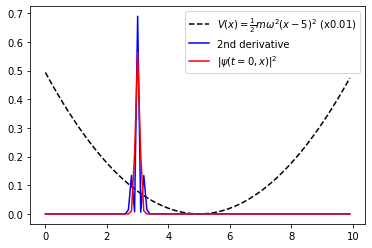

In [6]:
plt.plot(x, V_tensor * 0.001, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")
plt.plot(x, (torch.abs(psi_dd)**2/(torch.abs(psi_dd)**2).sum()).detach().numpy(), "b", label="2nd derivative")
plt.plot(x, (torch.abs(psi_tensor)**2/B).detach().numpy(), "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.legend()
plt.show()


In [ ]:
# use the 2nd derivative for getting the next point

### rk4 method
this method runs from left to right, which causes some instabilities

In [7]:
def sch_equation(Z, r, V, E):
    """by separation of variable, the sch equation
    Z contains psi and dx_psi (first derivative of psi)
    """
    psi, dx_psi = Z     
    dx_Z = [dx_psi, (V - E) * psi]
    return torch.tensor(dx_Z)

def rk4(f, psi, x, V, E):
    """Fourth-order Runge-Kutta method to solve phi' = f(psi, x) with psi(x[0]) = psi0.
    Integrates function f with initial values psi0 and potential V numerically.
    Output is a multidimensional tensor (in psi) with len(x)."""
    h = x[1] - x[0]
    n = len(x)
    for i in range(n - 2):
        k1 = h * f(psi[i], x[i], V[i], E)
        k2 = h * f(psi[i] + 0.5 * k1, x[i] + 0.5 * h, V[i], E)
        k3 = h * f(psi[i] + 0.5 * k2, x[i] + 0.5 * h, V[i], E)
        k4 = h * f(psi[i] + k3, x[i + 1], V[i], E)
        psi[i + 1] = psi[i] + (k1 + 2.0 * (k2 + k3) + k4) / 6.0
    return psi

`psi_init` its initialized with the boudary values for psi and its derivative

In [8]:
psi_0 = 0.0
dx_psi0 = 0.5 # derivative at bound
psi_init = torch.tensor([ psi_0 , dx_psi0 ], dtype=torch.float32)
n = len(x_tensor)
psi_init = torch.stack([psi_init] * n)
psi_init[:5]

tensor([[0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000]])

In [12]:
# E0 > V
E0 = 10
psi_2iter = rk4(sch_equation, psi_init, x_tensor, V_tensor, E0*1000)[:,0]
A = (torch.abs(psi_2iter)**2).sum()

In [14]:
psi_2iter

tensor([ 0.0000e+00, -7.4221e-01, -4.9151e+02, -2.2949e+05, -8.8243e+07,
        -2.8572e+10, -7.3778e+12, -1.1174e+15,  2.4845e+17,  3.2283e+20,
         1.8631e+23,  8.2825e+25,  3.0878e+28,  9.6313e+30,  2.2858e+33,
         2.1166e+35,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,     

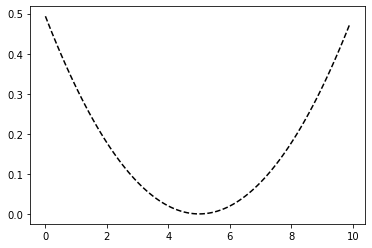

In [13]:
plt.plot(x, V_tensor*0.001, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")
plt.plot(x, (torch.abs(psi_2iter)**2/(torch.abs(psi_2iter)**2).sum()).detach().numpy(), "b")
# plt.legend()
plt.show()

### More on the method

In [74]:
from scipy.signal import argrelextrema

def countNodes(wavefunc):
    """Count nodes of wavefunc by finding Minima and Maxima in wavefunc."""
    wavefunc_np = wavefunc.detach().numpy()  # Convert tensor to NumPy array
    maxarray = argrelextrema(wavefunc_np, np.greater)[0]
    minarray = argrelextrema(wavefunc_np, np.less)[0]
    nodecounter = len(maxarray) + len(minarray)
    return nodecounter

print(countNodes(psi_tensor))
print(countNodes(psi_dd))

1
3


In [77]:
def findZeros( wavefunc ):
    """ Find zero crossing due to sign change array.
    Return array with array indices before sign change occurs .
    """
    wavefunc_np = wavefunc.detach().numpy()  # Convert tensor to NumPy array
    return np.where( np.diff( np .signbit(wavefunc_np)))[0]

findZeros(psi_dd)

array([28, 31], dtype=int64)

In [83]:
def RefineEnergy ( Ebot , Etop , Nodes , psi0 , x , V, E_tolerance=1e-12, psi_tolerance = 1e-3 ):
    tolerance = E_tolerance
    ET = Etop
    EB = Ebot
    psi = psi0[1]
    while ( abs(EB - ET ) > tolerance or abs ( psi[ -1]) > psi_tolerance):
        initE = ( ET + EB )/2.0
        psi = rk4 ( Schroed , psi0 , x , V , initE )[: , 0]
        nodes_ist = len( findZeros ( psi ))-1
        if nodes_ist > Nodes + 1:
            ET = initE
            continue
        if nodes_ist < Nodes - 1:
            EB = initE
            continue
        if ( nodes_ist % 2 == 0):
            if (( psi [ len ( psi ) -1] <= 0.0)):
                ET = initE
            else :
                EB = initE
        elif nodes_ist > 0:
            if (( psi [ len ( psi ) -1] <= 0.0)):
                EB = initE
            else :
                ET = initE
        elif nodes_ist < 0:
            EB = initE
        return EB , ET


$$
E_n = \hbar \omega ( n + \frac{1}{2})
$$

In [ ]:
psi_0 = 0.0
phi_0 = 1.0
psi_init = np . asarray ([ psi_0 , phi_0 ])
h_mesh = 1.0/100.0 # stepsize for range arrays
x_arr_ipw = np . arange (0.0 , 1.0+ h_mesh , h_mesh ) # set up mesh
V_ipw = np . zeros ( len ( x_arr_ipw )) # set up potential
EBref , ETref = RefineEnergy ( E_interval [0] , E_interval [1] , nodes , psi_init ,
x_arr_ipw , V_ipw )
psi = rk4 ( Schroed , psi_init , x_arr_ipw , V_ipw , EBref )[: , 0]

## Shooting Pytorch

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [80]:
def Schroed(Z, r, V, E):
    """Return one-dimensional Schroedinger equation with potential V.
    Z contains psi and dx_psi (first derivative of psi)
    """
    psi, dx_psi = psiphi     
    dx_Z = [dx_psi, (V - E) * psi]
    return torch.tensor(dx_Z)

def rk4(f, psi0, x, V, E):
    """Fourth-order Runge-Kutta method to solve phi' = f(psi, x) with psi(x[0]) = psi0.
    Integrates function f with initial values psi0 and potential V numerically.
    Output is a multidimensional tensor (in psi) with len(x)."""
    n = len(x)
    psi = torch.tensor([psi0] * n)
    for i in range(n - 1):
        h = x[i + 1] - x[i]
        k1 = h * f(psi[i], x[i], V[i], E)
        k2 = h * f(psi[i] + 0.5 * k1, x[i] + 0.5 * h, V[i], E)
        k3 = h * f(psi[i] + 0.5 * k2, x[i] + 0.5 * h, V[i], E)
        k4 = h * f(psi[i] + k3, x[i + 1], V[i], E)
        psi[i + 1] = psi[i] + (k1 + 2.0 * (k2 + k3) + k4) / 6.0
    return psi

In [ ]:
def findZeros ( rightbound_vals ):
    """ Find zero crossing due to sign change in r i g h t b o u n d _ v a l s array .
    Return array with array indices before sign change occurs .
    """
    return np . where ( np.diff ( np . signbit ( rightbound_vals )))[0]


In [ ]:
def normalize ( output_wavefunc ):
    """ A function to roughly normalize the wave function to 1. """
    normal = max ( output_wavefunc )
    return output_wavefunc *(1/( normal ))


In [42]:
from scipy.signal import argrelextrema

def countNodes ( wavefunc ):
    """ Count nodes of wavefunc by finding Minima and Maxima in wavefunc . """
    maxarray = argrelextrema ( wavefunc , np . greater )[0]
    minarray = argrelextrema ( wavefunc , np . less )[0]
    nodecounter = len ( maxarray )+ len ( minarray )
    return nodecounter


In [ ]:
def RefineEnergy ( Ebot , Etop , Nodes , psi0 , x , V, E_tolerance=1e-12, psi_tolerance = 1e-3 ):
    tolerance = E_tolerance
    ET = Etop
    EB = Ebot
    psi = [1]
    while ( abs(EB - ET ) > tolerance or abs ( psi[ -1]) > psi_tolerance):
        initE = ( ET + EB )/2.0
        psi = rk4 ( Schroed , psi0 , x , V , initE )[: , 0]
        nodes_ist = len( findZeros ( psi ))-1
        if nodes_ist > Nodes + 1:
            ET = initE
            continue
        if nodes_ist < Nodes - 1:
            EB = initE
            continue
        if ( nodes_ist % 2 == 0):
            if (( psi [ len ( psi ) -1] <= 0.0)):
                ET = initE
            else :
                EB = initE
        elif nodes_ist > 0:
            if (( psi [ len ( psi ) -1] <= 0.0)):
                EB = initE
            else :
                ET = initE
        elif nodes_ist < 0:
            EB = initE
        return EB , ET



In [ ]:
def ShootingInfinitePotentialWell ( E_interval , nodes ):
    """ I m p l e m e n t a t i o n of Shooting method for Infinite PotWell
    INPUT : E_interval array with top and bottom value , len ( E_interval )=2
    nodes : Number wavefunction nodes = > determins quantum state .
    OUTPUT : refined energy value
    numerical wavefunction as array .
    """
    psi_0 = 0.0
    phi_0 = 1.0
    psi_init = np . asarray ([ psi_0 , phi_0 ])
    h_mesh = 1.0/100.0 # stepsize for range arrays
    x_arr_ipw = np . arange (0.0 , 1.0+ h_mesh , h_mesh ) # set up mesh
    V_ipw = np . zeros ( len ( x_arr_ipw )) # set up potential
    EBref , ETref = RefineEnergy ( E_interval [0] , E_interval [1] , nodes , psi_init ,
    x_arr_ipw , V_ipw )
    psi = rk4 ( Schroed , psi_init , x_arr_ipw , V_ipw , EBref )[: , 0]
    return EBref , normalize ( psi ) , x_arr_ipw


In [ ]:
def IPW_ana (x , k ):
    """ Return analytical wavefunc of respective state ( k ) of IPW . """
    return np . asarray ( np . sin (k* np . pi *x ))


$$
E_n = \hbar \omega ( n + \frac{1}{2})
$$

In [ ]:
# Start
E_qho = [0.1 , 100.0]



In [ ]:
print("Welcome!")
print("Maximum quantum state is currently limited to the 4th excited state.")
print("\n")
print("Infinite Potential Well Shooting")
figipw = plt.figure()
for ii in nodes_arr:
    Energy, psi_ipw, x_ipw = ShootingInfinitePotentialWell(E_ipw, ii)
    psi_ana = normalize(IPW_ana(ii, x_ipw))
    print("Found quantum state at energy = %s [Hartree]" % Energy)
    plt.cla()  # clear axis
    plt.clf()  # clear figure
    plt.plot(x_ipw, psi_ipw, 'b-.', label=r'$\Psi(x)_{num}$')
    plt.plot(x_ipw, psi_ana, 'r--', label=r'$\Psi(x)_{ana}$')
    plt.title('Eigenstate: %s' % ii)
    plt.legend(loc='best', fontsize='small')
    plt.grid()
    figipw.savefig('plots/ipw_shoottest_state_' + str(ii) + '.png')
    print("\n")
print("Quantum Harmonic Oscillator Shooting:")
figqho = plt.figure()
for ii in nodes_arr:
    EB, ET, psibot, psitop, x_qho = ShootingQuantumHarmonicOscillator(E_qho, ii)
    psi_ana = QHO_ana(x_qho, ii)
    print("Found quantum state at energy = %s [Hartree]" % ET)
    plt.cla()  # clear axis
    plt.clf()  # clear figure
    plt.plot(x_qho, psitop, 'b-.', label=r'$\Psi(x)_{num}$')
    plt.plot(x_qho, normalize(psi_ana), 'r--', label=r'$\Psi(x)_{ana}$')
    plt.title('Eigenstate: %s' % ii)
    plt.legend(loc='best', fontsize='small')
    plt.grid()
    figqho.savefig('plots/qho_shoottest_state_' + str(ii) + '.png')
    print("\n")
print("Please find plots of wavefunctions in 'plots' folder.")
print("\nGoodbye.")
